# Hyperparameter Optimization with Optuna

Welcome to the Optuna-based hyperparameter optimization tutorial! In this interactive notebook, you will explore world of hyperparameter tuning for a Convolutional Neural Network (CNN) specifically aimed at image classification using the CIFAR-10 dataset. Hyperparameter optimization is pivotal in enhancing model performance, making your models more accurate and efficient.

Optuna, a robust and versatile library, plays a central role in automating and streamlining this process. It empowers you to navigate through complex hyperparameter spaces with ease. In this tutorial, you will engage with Optuna's core functionalities, and you'll also have the opportunity to construct a flexible CNN architecture. This adaptable design is essential for understanding how models can be fine-tuned effortlessly to suit various hyperparameter configurations.

Throughout this session, you will:
- Learn how to set up and execute an Optuna study, incorporating all essential elements required for effective hyperparameter optimization.
- Perform a thorough analysis of the results to evaluate how different hyperparameters influence model performance, gaining insights into their practical impact.

Additionally, this tutorial includes an optional section where you will compare two prevalent methods of hyperparameter optimization: Optuna's default sampling method (Tree-structured Parzen Estimator, or TPE) and the traditional Grid Search method. This comparison will not only highlight the strengths of Optuna but also provide a clearer perspective on how it can outperform conventional optimization techniques.


## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import helper_utils
import torch.nn.functional as F
from pprint import pprint

helper_utils.set_seed(15)

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Hyperparameter Optimization for CNNs on CIFAR-10

In this section, you explore the vital task of finding the optimal hyperparameters for a Convolutional Neural Network (CNN) tailored to the CIFAR-10 dataset. 
Utilizing Optuna, a sophisticated framework for hyperparameter optimization, your goal is to streamline and automate the process, ensuring efficiency and effectiveness. 
The selection of hyperparameters is notably intensive computationally and depends on various factors including the architecture of the model, the dataset characteristics, and the specific training processes involved. These elements, collectively and individually, have significant impacts on the performance outcomes of the model.

### Defining a Flexible CNN Architecture

The model architecture here is deliberately designed to be flexible, accommodating variability in its layers which is pivotal for adapting to different hyperparameter configurations suggested by Optuna during optimization trials.  
The architecture is defined in a modular manner, allowing for easy adjustments and experimentation with different layer configurations, activation functions, and other hyperparameters. 

`FlexibleCNN` is a class that encapsulates the architecture of the CNN model:

* **`__init__`**: The constructor initializes the model's feature extraction layers.
>    * It constructs a series of convolutional blocks based on the `n_layers` parameter. Each block is a sequence of `nn.Conv2d`, `nn.ReLU`, and `nn.MaxPool2d`.
>    * The `in_channels` for each block is set to the `out_channels` of the preceding block to ensure a seamless data flow.
>    * All blocks are combined into a single `nn.Sequential` module assigned to the `.features` attribute, which handles feature extraction.
>    * The classifier, `.classifier`, is initially set to `None` and will be constructed dynamically later.
 * **`_create_classifier`**: This helper method dynamically builds the classifier part of the network.
>    * It's called during the first forward pass once the input size for the linear layers is known.
 * **`forward`**: This method defines the forward pass of the model.
>    * The input `x` first passes through the `.features` layers.
>    * The output from the feature extractor is flattened to determine the input size for the classifier.
>    * If the `.classifier` has not been created yet, it calls `_create_classifier` to build it on the fly.
>    * Finally, the flattened data is passed through the `.classifier` to produce the final output.

In [3]:
class FlexibleCNN(nn.Module):
    """
    A flexible Convolutional Neural Network with a dynamically created classifier.

    This CNN's architecture is defined by the provided hyperparameters,
    allowing for a variable number of convolutional layers. The classifier
    (fully connected layers) is constructed during the first forward pass
    to adapt to the output size of the convolutional feature extractor.
    """
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout_rate, fc_size):
        """
        Initializes the feature extraction part of the CNN.

        Args:
            n_layers: The number of convolutional blocks to create.
            n_filters: A list of integers specifying the number of output
                       filters for each convolutional block.
            kernel_sizes: A list of integers specifying the kernel size for
                          each convolutional layer.
            dropout_rate: The dropout probability to be used in the classifier.
            fc_size: The number of neurons in the hidden fully connected layer.
        """
        super(FlexibleCNN, self).__init__()

        # Initialize an empty list to hold the convolutional blocks
        blocks = []
        # Set the initial number of input channels for RGB images
        in_channels = 3

        # Loop to construct each convolutional block
        for i in range(n_layers):

            # Get the parameters for the current convolutional layer
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]
            # Calculate padding to maintain the input spatial dimensions ('same' padding)
            padding = (kernel_size - 1) // 2

            # Define a block as a sequence of Conv, ReLU, and MaxPool layers
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            
            # Add the newly created block to the list
            blocks.append(block)

            # Update the number of input channels for the next block
            in_channels = out_channels

        # Combine all blocks into a single feature extractor module
        self.features = nn.Sequential(*blocks)

        # Store hyperparameters needed for building the classifier later
        self.dropout_rate = dropout_rate
        self.fc_size = fc_size

        # The classifier will be initialized dynamically in the forward pass
        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        """
        Dynamically creates and initializes the classifier part of the network.

        This helper method is called during the first forward pass to build the
        fully connected layers based on the feature map size from the
        convolutional base.

        Args:
            flattened_size: The number of input features for the first linear
                            layer, determined from the flattened feature map.
            device: The device to which the new classifier layers should be moved.
        """
        # Define the classifier's architecture
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.fc_size, 10)  # Assumes 10 output classes (e.g., CIFAR-10)
        ).to(device)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor of shape (batch_size, channels, height, width).

        Returns:
            The output logits from the classifier.
        """
        # Get the device of the input tensor to ensure consistency
        device = x.device

        # Pass the input through the feature extraction layers
        x = self.features(x)

        # Flatten the feature map to prepare it for the fully connected layers
        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        # If the classifier has not been created yet, initialize it
        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        # Pass the flattened features through the classifier to get the final output
        return self.classifier(flattened)

## Defining the Optuna Objective Function

The objective function is the core of the hyperparameter optimization process, being the function that Optuna will repeatedly call to evaluate different hyperparameter configurations.
This function encapsulates the entire training and evaluation process, including the definition of the CNN model architecture, the optimizer, the data loaders, the training loop, and the evaluation metrics.
Within this function, you define the search space for hyperparameters using `trial.suggest_*` methods, which allow Optuna to sample hyperparameters from a defined range or set of values. 
For a full list of available `suggest_*` methods, you can refer to the [Optuna documentation](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html).

*The objective function is designed to return a single scalar value, which represents the performance of the model for the given hyperparameters*. 
In your case, the aim to maximize the accuracy of the model on the validation set, which is computed using the `evaluate_accuracy` function.

Observe that some hyperparameters are defined as fixed values, such as the number of epochs, the batch size, and the learning rate.

In [4]:
def objective(trial, device):
    """
    Defines the objective function for hyperparameter optimization using Optuna.

    For each trial, this function samples a set of hyperparameters,
    constructs a model, trains it for a fixed number of epochs, evaluates
    its performance on a validation set, and returns the accuracy. Optuna
    uses the returned accuracy to guide its search for the best
    hyperparameter combination.

    Args:
        trial: An Optuna `Trial` object, used to sample hyperparameters.
        device: The device ('cpu' or 'cuda') for model training and evaluation.

    Returns:
        The validation accuracy of the trained model as a float.
    """
    # Sample hyperparameters for the feature extractor using the Optuna trial
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_filters = [trial.suggest_int(f"n_filters_{i}", 16, 128) for i in range(n_layers)]
    kernel_sizes = [trial.suggest_categorical(f"kernel_size_{i}", [3, 5]) for i in range(n_layers)]

    # Sample hyperparameters for the classifier
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    fc_size = trial.suggest_int("fc_size", 64, 256)

    # Instantiate the model with the sampled hyperparameters
    model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout_rate, fc_size).to(device)

    # Define fixed training parameters: learning rate, loss function, and optimizer
    learning_rate = 0.001
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define fixed data loading parameters and create data loaders
    batch_size = 128
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Define the fixed number of epochs for training
    n_epochs = 10
    # Train the model using a helper function
    helper_utils.train_model(
        model=model,
        optimizer=optimizer,
        train_dataloader=train_loader,
        n_epochs=n_epochs,
        loss_fcn=loss_fcn,
        device=device
    )

    # Evaluate the trained model's accuracy on the validation set
    accuracy = helper_utils.evaluate_accuracy(model, val_loader, device)
    
    # Return the final accuracy for this trial
    return accuracy

## Running the Optuna Study

Once that the objective function is defined, an Optuna study is created to manage the hyperparameter optimization process.
The study is responsible for running the objective function multiple times with different hyperparameter configurations, allowing Optuna to explore the search space and find the best hyperparameters.
In this case, your goal is to **maximize the accuracy** of the CNN model on the CIFAR-10 dataset, this is why we use `direction='maximize'` when creating the study.
The `optimize` method of the study is called to start the optimization process, which will run the objective function for a defined number of trials.

A lambda function is used to pass the device to the objective function, allowing the model to be trained on the specified device
*Note*: you can also pass other parameters to the objective function using the lambda function, if needed.

**NOTE:** the code below will take about 5 minutes to run.

In [5]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize') # The goal in this case is to maximize accuracy

# Start the optimization process (it takes about 8 minutes for 20 trials)
n_trials = 20
study.optimize(lambda trial: objective(trial, device), n_trials=n_trials) # use more trials in practice

[I 2025-11-15 05:03:37,196] A new study created in memory with name: no-name-c432214a-b9af-481a-bbc6-dc81f64ea037


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.7991
Epoch 10 - Train Loss: 1.6292
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:03:56,766] Trial 0 finished with value: 0.4985 and parameters: {'n_layers': 3, 'n_filters_0': 110, 'n_filters_1': 76, 'n_filters_2': 29, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.2560921613453114, 'fc_size': 131}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.1199
Epoch 10 - Train Loss: 2.0302
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:04:13,126] Trial 1 finished with value: 0.3765 and parameters: {'n_layers': 2, 'n_filters_0': 17, 'n_filters_1': 124, 'kernel_size_0': 5, 'kernel_size_1': 3, 'dropout_rate': 0.44668919507029414, 'fc_size': 64}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2769
Epoch 10 - Train Loss: 2.2556
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:04:29,288] Trial 2 finished with value: 0.1845 and parameters: {'n_layers': 1, 'n_filters_0': 34, 'kernel_size_0': 3, 'dropout_rate': 0.19954088880039303, 'fc_size': 134}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2391
Epoch 10 - Train Loss: 2.2090
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:04:45,878] Trial 3 finished with value: 0.2515 and parameters: {'n_layers': 1, 'n_filters_0': 71, 'kernel_size_0': 3, 'dropout_rate': 0.22957170629597257, 'fc_size': 149}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.0837
Epoch 10 - Train Loss: 2.0059
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:05:04,011] Trial 4 finished with value: 0.37 and parameters: {'n_layers': 2, 'n_filters_0': 116, 'n_filters_1': 105, 'kernel_size_0': 3, 'kernel_size_1': 3, 'dropout_rate': 0.44052609190700664, 'fc_size': 107}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2424
Epoch 10 - Train Loss: 2.2080
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:05:20,138] Trial 5 finished with value: 0.224 and parameters: {'n_layers': 1, 'n_filters_0': 98, 'kernel_size_0': 3, 'dropout_rate': 0.28081189813543106, 'fc_size': 93}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.1232
Epoch 10 - Train Loss: 2.0509
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:05:36,873] Trial 6 finished with value: 0.3815 and parameters: {'n_layers': 2, 'n_filters_0': 64, 'n_filters_1': 110, 'kernel_size_0': 3, 'kernel_size_1': 3, 'dropout_rate': 0.4539136067959325, 'fc_size': 115}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9755
Epoch 10 - Train Loss: 1.8817
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:05:54,720] Trial 7 finished with value: 0.4435 and parameters: {'n_layers': 2, 'n_filters_0': 85, 'n_filters_1': 90, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.4284957344070158, 'fc_size': 138}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2649
Epoch 10 - Train Loss: 2.2439
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:06:10,270] Trial 8 finished with value: 0.1265 and parameters: {'n_layers': 1, 'n_filters_0': 31, 'kernel_size_0': 3, 'dropout_rate': 0.1462021923720919, 'fc_size': 111}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.8731
Epoch 10 - Train Loss: 1.7293
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:06:27,893] Trial 9 finished with value: 0.4485 and parameters: {'n_layers': 2, 'n_filters_0': 68, 'n_filters_1': 87, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.2641444845532646, 'fc_size': 240}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9878
Epoch 10 - Train Loss: 1.8658
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:06:45,061] Trial 10 finished with value: 0.4575 and parameters: {'n_layers': 3, 'n_filters_0': 124, 'n_filters_1': 39, 'n_filters_2': 18, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.36691148463740064, 'fc_size': 211}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9736
Epoch 10 - Train Loss: 1.8423
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:07:02,641] Trial 11 finished with value: 0.4225 and parameters: {'n_layers': 3, 'n_filters_0': 128, 'n_filters_1': 42, 'n_filters_2': 16, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.3368935618968432, 'fc_size': 197}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.8960
Epoch 10 - Train Loss: 1.7818
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:07:19,912] Trial 12 finished with value: 0.463 and parameters: {'n_layers': 3, 'n_filters_0': 103, 'n_filters_1': 45, 'n_filters_2': 21, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.33569883814486057, 'fc_size': 187}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9565
Epoch 10 - Train Loss: 1.8033
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:07:36,891] Trial 13 finished with value: 0.4485 and parameters: {'n_layers': 3, 'n_filters_0': 100, 'n_filters_1': 62, 'n_filters_2': 57, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 3, 'dropout_rate': 0.34457650183669264, 'fc_size': 180}. Best is trial 0 with value: 0.4985.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5201
Epoch 10 - Train Loss: 1.2603
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:07:54,242] Trial 14 finished with value: 0.5215 and parameters: {'n_layers': 3, 'n_filters_0': 107, 'n_filters_1': 62, 'n_filters_2': 56, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.10518242931047969, 'fc_size': 173}. Best is trial 14 with value: 0.5215.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5642
Epoch 10 - Train Loss: 1.3516
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:08:11,260] Trial 15 finished with value: 0.5185 and parameters: {'n_layers': 3, 'n_filters_0': 87, 'n_filters_1': 17, 'n_filters_2': 72, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.10909255914406157, 'fc_size': 162}. Best is trial 14 with value: 0.5215.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5084
Epoch 10 - Train Loss: 1.3040
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:08:28,375] Trial 16 finished with value: 0.536 and parameters: {'n_layers': 3, 'n_filters_0': 85, 'n_filters_1': 20, 'n_filters_2': 97, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.10354880381769226, 'fc_size': 168}. Best is trial 16 with value: 0.536.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6644
Epoch 10 - Train Loss: 1.4873
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:08:45,365] Trial 17 finished with value: 0.4745 and parameters: {'n_layers': 3, 'n_filters_0': 84, 'n_filters_1': 19, 'n_filters_2': 117, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 3, 'dropout_rate': 0.16323660249402785, 'fc_size': 237}. Best is trial 16 with value: 0.536.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.4146
Epoch 10 - Train Loss: 1.0984
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:09:02,219] Trial 18 finished with value: 0.572 and parameters: {'n_layers': 3, 'n_filters_0': 54, 'n_filters_1': 55, 'n_filters_2': 108, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.10181440847292397, 'fc_size': 168}. Best is trial 18 with value: 0.572.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5388
Epoch 10 - Train Loss: 1.3066
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 05:09:18,846] Trial 19 finished with value: 0.5295 and parameters: {'n_layers': 3, 'n_filters_0': 53, 'n_filters_1': 31, 'n_filters_2': 110, 'kernel_size_0': 5, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.1628250333966443, 'fc_size': 217}. Best is trial 18 with value: 0.572.


Evaluation complete.


### Analyzing the Results
After the optimization process is complete, you can analyze the results to understand which hyperparameters yielded the best performance.
The `study` object contains a wealth of information about the trials, including the hyperparameters sampled, the corresponding performance metrics, and the best trial.

You can access the full DataFrame of trials using the `trials_dataframe()` method, which provides a comprehensive overview of all the trials conducted during the optimization process.
This DataFrame includes columns for the trial number, hyperparameters, and the objective value (in our case, the accuracy).

To access the best hyperparameters and the best trial, you can use the `best_trial` attributes of the study object.

**Note:** these results may change every time you re-run the training study.

In [6]:
# Extract the dataframe with the results
df = study.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_fc_size,params_kernel_size_0,params_kernel_size_1,params_kernel_size_2,params_n_filters_0,params_n_filters_1,params_n_filters_2,params_n_layers,state
0,0,0.4985,2025-11-15 05:03:37.197292,2025-11-15 05:03:56.766205,0 days 00:00:19.568913,0.256092,131,5,3.0,5.0,110,76.0,29.0,3,COMPLETE
1,1,0.3765,2025-11-15 05:03:56.767083,2025-11-15 05:04:13.126618,0 days 00:00:16.359535,0.446689,64,5,3.0,NaN,17,124.0,NaN,2,COMPLETE
2,2,0.1845,2025-11-15 05:04:13.127542,2025-11-15 05:04:29.287962,0 days 00:00:16.160420,0.199541,134,3,NaN,NaN,34,NaN,NaN,1,COMPLETE
3,3,0.2515,2025-11-15 05:04:29.288795,2025-11-15 05:04:45.878312,0 days 00:00:16.589517,0.229572,149,3,NaN,NaN,71,NaN,NaN,1,COMPLETE
4,4,0.3700,2025-11-15 05:04:45.879177,2025-11-15 05:05:04.011370,0 days 00:00:18.132193,0.440526,107,3,3.0,NaN,116,105.0,NaN,2,COMPLETE
5,5,0.2240,2025-11-15 05:05:04.012161,2025-11-15 05:05:20.138627,0 days 00:00:16.126466,0.280812,93,3,NaN,NaN,98,NaN,NaN,1,COMPLETE
6,6,0.3815,2025-11-15 05:05:20.139435,2025-11-15 05:05:36.873119,0 days 00:00:16.733684,0.453914,115,3,3.0,NaN,64,110.0,NaN,2,COMPLETE
7,7,0.4435,2025-11-15 05:05:36.873860,2025-11-15 05:05:54.719754,0 days 00:00:17.845894,0.428496,138,5,5.0,NaN,85,90.0,NaN,2,COMPLETE
8,8,0.1265,2025-11-15 05:05:54.720569,2025-11-15 05:06:10.269817,0 days 00:00:15.549248,0.146202,111,3,NaN,NaN,31,NaN,NaN,1,COMPLETE
9,9,0.4485,2025-11-15 05:06:10.270590,2025-11-15 05:06:27.892880,0 days 00:00:17.622290,0.264144,240,5,5.0,NaN,68,87.0,NaN,2,COMPLETE


In [7]:
# Extract and print the best trial
best_trial = study.best_trial

print("Best trial:")
print(f"  Value (Accuracy): {best_trial.value:.4f}")

print("  Hyperparameters:")
pprint(best_trial.params)

Best trial:
  Value (Accuracy): 0.5720
  Hyperparameters:
{'dropout_rate': 0.10181440847292397,
 'fc_size': 168,
 'kernel_size_0': 5,
 'kernel_size_1': 5,
 'kernel_size_2': 5,
 'n_filters_0': 54,
 'n_filters_1': 55,
 'n_filters_2': 108,
 'n_layers': 3}


## Visualizing the Results

Optuna provides several built-in visualization functions to help analyze the results of the hyperparameter optimization process.
These visualizations can provide valuable insights into the optimization process and the impact of different hyperparameters on the model's performance:
- `plot_optimization_history`: This plot shows the optimization history of the objective function, allowing you to see how the performance of the model improved over time. It provides a visual representation of the objective values (in this case, accuracy) across different trials.
- `plot_param_importances`: This plot shows the importance of each hyperparameter in the optimization process. It helps identify which hyperparameters had the most significant impact on the model's performance, allowing you to focus on the most influential hyperparameters in future experiments.
- `plot_parallel_coordinate`: This plot visualizes the relationship between different hyperparameters and the objective function. It allows you to see how different hyperparameter configurations affected the model's performance, providing insights into the interactions between hyperparameters and their impact on the objective value.

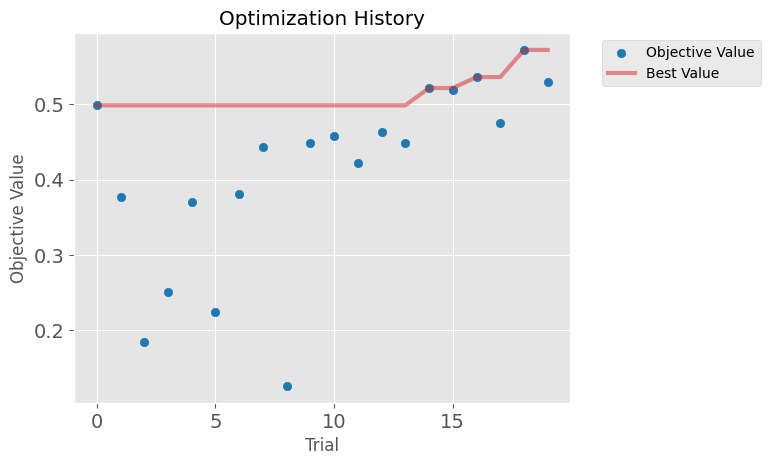

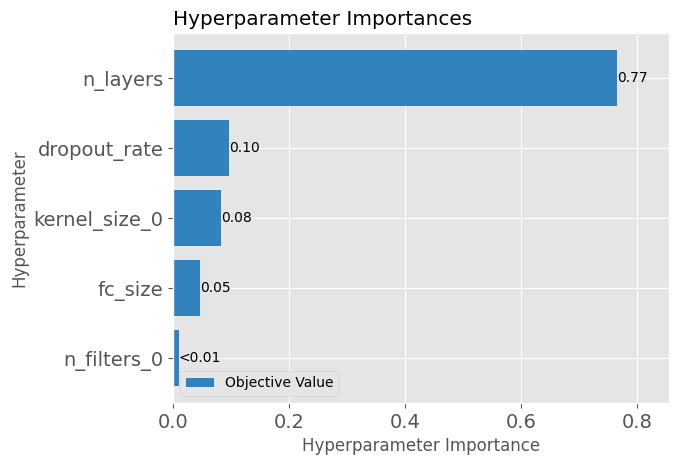

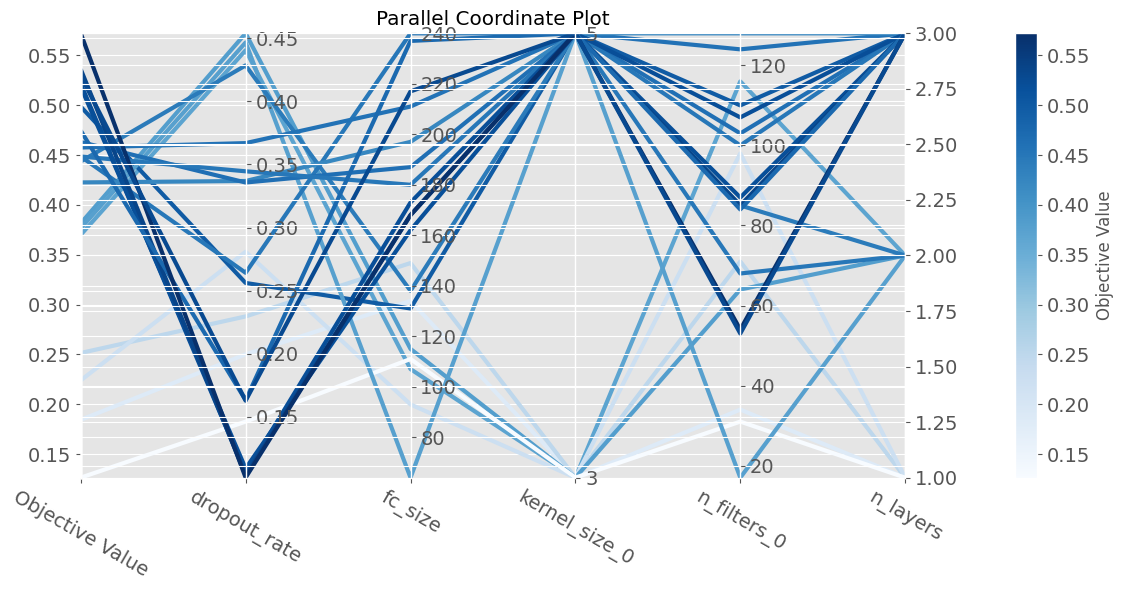

In [8]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

# Importance of hyperparameters
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

ax = optuna.visualization.matplotlib.plot_parallel_coordinate(
    study, params=['n_layers', 'n_filters_0', 'kernel_size_0', 'dropout_rate', 'fc_size']
)
fig = ax.figure
fig.set_size_inches(12, 6, forward=True)  # forward=True updates the canvas
fig.tight_layout()

## (Optional) Comparing Grid Search with Optuna's Default Search

In this section, you will compare the performance of Optuna's default search algorithm with a grid search approach.
Grid search is a traditional method for hyperparameter optimization that exhaustively searches through a predefined set of hyperparameter combinations.
While it can be effective, it is often computationally expensive and may not explore the search space as efficiently as Optuna's adaptive algorithms.

To perform the comparison, a simpler example is used, such as the one from previous labs. 
The `FlexibleSimpleCNN` model is used on a smaller dataset, consisting in a subset of the [Fruit and Vegetable Disease (Healthy vs Rotten)](https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten).
This dataset contains images of healthy and rotten fruits and vegetables. 
You will only use a custom subset of the dataset, which contains 1200 images of apples, 1000 being healthy and 200 being rotten. 

In [9]:
class FlexibleSimpleCNN(nn.Module):
    """
    A simple, flexible Convolutional Neural Network.

    This network consists of two convolutional layers, each followed by a
    max-pooling layer, and two fully connected layers. The number of filters
    in the convolutional layers and the size of the hidden linear layer are
    configurable, making the architecture adaptable to different requirements.
    """
    def __init__(self, conv1_out, conv2_out, fc_size, num_classes):
        """
        Initializes the layers of the CNN.

        Args:
            conv1_out: The number of output channels for the first
                       convolutional layer.
            conv2_out: The number of output channels for the second
                       convolutional layer.
            fc_size: The number of neurons in the hidden fully connected layer.
            num_classes: The number of output classes for the final layer.
        """
        super(FlexibleSimpleCNN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=3, padding=1)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        # Define a max pooling layer to be used after each convolution
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define the first fully connected (hidden) layer
        # Assumes input images are 32x32, resulting in an 8x8 feature map after two pooling layers
        self.fc1 = nn.Linear(conv2_out * 8 * 8, fc_size)
        # Define the final fully connected (output) layer
        self.fc2 = nn.Linear(fc_size, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x: The input tensor of shape (batch_size, channels, height, width).

        Returns:
            The output logits from the network.
        """
        # Apply the first convolutional block: convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply the second convolutional block
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature map to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        # Pass through the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Pass through the final output layer
        x = self.fc2(x)
        # Return the resulting logits
        return x

The goal of the model is to classify the images into two classes: healthy and rotten.
Note that the dataset is imbalanced, with a higher number of healthy images compared to rotten ones.
In such cases, accuracy is not the best metric to evaluate model performance, as it can be misleading due to the class imbalance.
Therefore, the **F1 score will be used as the evaluation metric**, as it is more suitable for imbalanced datasets. 
To ensure a fair comparison between grid search and Optuna's search, the same hyperparameter space will be used for both approaches.

You will also use the `trial.set_user_attr` method, which allows you to store additional information in each trial object, such as accuracy, recall, precision, and F1 score.
This is useful for tracking additional metrics that can be analyzed later.

In [10]:
def objective_apples(trial, device):
    """
    Defines the Optuna objective function for a CNN on an apple dataset.

    For each trial, this function samples hyperparameters for a CNN
    architecture, trains the model on a custom apple dataset, and evaluates
    its performance. It logs accuracy, precision, and recall, while
    returning the F1-score as the primary metric for Optuna to optimize.

    Args:
        trial: An Optuna `Trial` object used to sample hyperparameters.
        device: The device ('cpu' or 'cuda') for model training and evaluation.

    Returns:
        The F1-score of the trained model on the validation set.
    """
    # Sample a set of hyperparameters for the model architecture
    conv1_out = trial.suggest_int("conv1_out", 8, 64, step=8)
    conv2_out = trial.suggest_int("conv2_out", 16, 128, step=16)
    fc_size = trial.suggest_int("fc_size", 32, 256, step=32)

    # Define fixed parameters for the data loaders
    img_size = 32
    batch_size = 128

    # Create the training and validation data loaders for the apple dataset
    train_loader, val_loader = helper_utils.get_apples_dataset_dataloaders(
        img_size=img_size,
        batch_size=batch_size
    )

    # Specify the number of output classes for the dataset
    num_classes = 2
    # Create an instance of the model with the sampled hyperparameters
    model = FlexibleSimpleCNN(
        conv1_out=conv1_out,
        conv2_out=conv2_out,
        fc_size=fc_size,
        num_classes=num_classes
    ).to(device)
    
    # Define fixed training components: learning rate, optimizer, and loss function
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fcn = nn.CrossEntropyLoss()

    # Set the fixed number of epochs for the training loop
    n_epochs = 5
    # Train the model using a helper function
    helper_utils.train_model(
        model=model,
        optimizer=optimizer,
        train_dataloader=train_loader,
        n_epochs=n_epochs,
        loss_fcn=loss_fcn,
        device=device
    )

    # Evaluate the trained model on the validation set to get performance metrics
    accuracy, precision, recall, f1 = helper_utils.evaluate_metrics(
        model, val_loader, device, num_classes=2
    )

    # Log additional metrics to the Optuna trial for more detailed analysis
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)

    # Return the F1-score as the objective value for Optuna to maximize
    return f1

With the objective function defined, you can now run both the default Optuna search algorithm and the grid search algorithm. Both methods will be executed for the same number of trials, and the results will be compared using the `plot_optimization_history` function.

First, in this case, you will specify `sampler = optuna.samplers.TPESampler(seed=42)` (the default sampler in Optuna), which is the Tree-structured Parzen Estimator (TPE) sampler. The TPE sampler is a sophisticated algorithm that adapts the search space based on the results of previous trials, allowing for more efficient exploration of the hyperparameter space. Then, you will create a study object with the desired sampler and set `direction='maximize'` to indicate that you want to maximize the objective function (in this case, the F1 score). Note that the trials dataframe now includes additional columns for accuracy, recall, and precision, which were set using the `trial.set_user_attr` method inside the objective function.

Next, run the grid search sampler (`sampler = optuna.samplers.GridSampler(param_grid)`) to explore the hyperparameter space. The grid search will iterate, until reaching the number of trials defined, over all possible combinations of hyperparameters in the grid, evaluating the objective function for each unique configuration without repeating any combination.

In [11]:
seed = 42
helper_utils.set_seed(seed)

sampler = optuna.samplers.TPESampler(seed=seed)  # Use TPE sampler (the default sampler in Optuna)

# Create a study object and optimize the objective function
study_apples = optuna.create_study(direction='maximize', sampler=sampler)

n_trials = 10
study_apples.optimize(lambda trial: objective_apples(trial, device), n_trials=n_trials)  

[I 2025-11-15 05:09:20,155] A new study created in memory with name: no-name-f20515f5-60b5-4513-a409-eb219f6fc8d0


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3549
Training complete!



[I 2025-11-15 05:10:15,412] Trial 0 finished with value: 0.6255446672439575 and parameters: {'conv1_out': 24, 'conv2_out': 128, 'fc_size': 192}. Best is trial 0 with value: 0.6255446672439575.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.4516
Training complete!



[I 2025-11-15 05:11:03,350] Trial 1 finished with value: 0.439461886882782 and parameters: {'conv1_out': 40, 'conv2_out': 32, 'fc_size': 64}. Best is trial 0 with value: 0.6255446672439575.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3359
Training complete!



[I 2025-11-15 05:11:52,607] Trial 2 finished with value: 0.7176079750061035 and parameters: {'conv1_out': 8, 'conv2_out': 112, 'fc_size': 160}. Best is trial 2 with value: 0.7176079750061035.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3462
Training complete!



[I 2025-11-15 05:12:40,183] Trial 3 finished with value: 0.6919227838516235 and parameters: {'conv1_out': 48, 'conv2_out': 16, 'fc_size': 256}. Best is trial 2 with value: 0.7176079750061035.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3492
Training complete!



[I 2025-11-15 05:13:28,497] Trial 4 finished with value: 0.8566513657569885 and parameters: {'conv1_out': 56, 'conv2_out': 32, 'fc_size': 64}. Best is trial 4 with value: 0.8566513657569885.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3716
Training complete!



[I 2025-11-15 05:14:18,092] Trial 5 finished with value: 0.5040310621261597 and parameters: {'conv1_out': 16, 'conv2_out': 48, 'fc_size': 160}. Best is trial 4 with value: 0.8566513657569885.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2963
Training complete!



[I 2025-11-15 05:15:10,592] Trial 6 finished with value: 0.7342193126678467 and parameters: {'conv1_out': 32, 'conv2_out': 48, 'fc_size': 160}. Best is trial 4 with value: 0.8566513657569885.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2837
Training complete!



[I 2025-11-15 05:15:57,793] Trial 7 finished with value: 0.858942985534668 and parameters: {'conv1_out': 16, 'conv2_out': 48, 'fc_size': 96}. Best is trial 7 with value: 0.858942985534668.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3145
Training complete!



[I 2025-11-15 05:16:46,882] Trial 8 finished with value: 0.9125000238418579 and parameters: {'conv1_out': 32, 'conv2_out': 112, 'fc_size': 64}. Best is trial 8 with value: 0.9125000238418579.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3693
Training complete!



[I 2025-11-15 05:17:33,687] Trial 9 finished with value: 0.6905393600463867 and parameters: {'conv1_out': 40, 'conv2_out': 80, 'fc_size': 32}. Best is trial 8 with value: 0.9125000238418579.


In [12]:
df_apples_study = study_apples.trials_dataframe()

df_apples_study

,number,value,datetime_start,datetime_complete,duration,params_conv1_out,params_conv2_out,params_fc_size,user_attrs_accuracy,user_attrs_precision,user_attrs_recall,state
0,0,0.625545,2025-11-15 05:09:20.155739,2025-11-15 05:10:15.412531,0 days 00:00:55.256792,24,128,192,0.824,0.839588,0.606009,COMPLETE
1,1,0.439462,2025-11-15 05:10:15.413395,2025-11-15 05:11:03.349887,0 days 00:00:47.936492,40,32,64,0.784,0.392000,0.500000,COMPLETE
2,2,0.717608,2025-11-15 05:11:03.350778,2025-11-15 05:11:52.607768,0 days 00:00:49.256990,8,112,160,0.864,0.860886,0.676211,COMPLETE
3,3,0.691923,2025-11-15 05:11:52.608634,2025-11-15 05:12:40.183465,0 days 00:00:47.574831,48,16,256,0.868,0.807815,0.654647,COMPLETE
4,4,0.856651,2025-11-15 05:12:40.184205,2025-11-15 05:13:28.497271,0 days 00:00:48.313066,56,32,64,0.936,0.915296,0.817282,COMPLETE
5,5,0.504031,2025-11-15 05:13:28.497975,2025-11-15 05:14:18.092603,0 days 00:00:49.594628,16,48,160,0.812,0.904858,0.530000,COMPLETE
6,6,0.734219,2025-11-15 05:14:18.093591,2025-11-15 05:15:10.592415,0 days 00:00:52.498824,32,48,160,0.872,0.930736,0.686275,COMPLETE
7,7,0.858943,2025-11-15 05:15:10.593239,2025-11-15 05:15:57.793829,0 days 00:00:47.200590,16,48,96,0.916,0.899405,0.830574,COMPLETE
8,8,0.912500,2025-11-15 05:15:57.794736,2025-11-15 05:16:46.882267,0 days 00:00:49.087531,32,112,64,0.944,0.912500,0.912500,COMPLETE
9,9,0.690539,2025-11-15 05:16:46.883146,2025-11-15 05:17:33.687018,0 days 00:00:46.803872,40,80,32,0.860,0.847701,0.652185,COMPLETE


In [13]:
# Run with Grid Search Sampler

# Define the hyperparameter grid
param_grid = {
    "conv1_out": list(range(8, 65, 8)),       # [8, 16, 24, 32, 40, 48, 56, 64]
    "conv2_out": list(range(16, 129, 16)),    # [16, 32, 48, 64, 80, 96, 112, 128]
    "fc_size":   list(range(32, 257, 32))     # [32, 64, 96, 128, 160, 192, 224, 256]
}

# Create a GridSampler with the defined grid
grid_sampler = optuna.samplers.GridSampler(param_grid, seed=seed)  # Use seed for reproducibility

# Create a study object with the GridSampler
study_grid = optuna.create_study(direction='maximize', sampler=grid_sampler)

study_grid.optimize(lambda trial: objective_apples(trial, device), n_trials=n_trials)

[I 2025-11-15 05:17:33,705] A new study created in memory with name: no-name-fbc2e859-455b-4857-92f3-51565887ba79


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3343
Training complete!



[I 2025-11-15 05:18:14,242] Trial 0 finished with value: 0.4343891441822052 and parameters: {'conv1_out': 40, 'conv2_out': 112, 'fc_size': 32}. Best is trial 0 with value: 0.4343891441822052.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3459
Training complete!



[I 2025-11-15 05:18:52,769] Trial 1 finished with value: 0.44933921098709106 and parameters: {'conv1_out': 64, 'conv2_out': 96, 'fc_size': 256}. Best is trial 1 with value: 0.44933921098709106.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2648
Training complete!



[I 2025-11-15 05:19:32,948] Trial 2 finished with value: 0.7996795177459717 and parameters: {'conv1_out': 56, 'conv2_out': 112, 'fc_size': 256}. Best is trial 2 with value: 0.7996795177459717.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2756
Training complete!



[I 2025-11-15 05:20:14,758] Trial 3 finished with value: 0.8275692462921143 and parameters: {'conv1_out': 24, 'conv2_out': 64, 'fc_size': 64}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3039
Training complete!



[I 2025-11-15 05:20:55,585] Trial 4 finished with value: 0.8207193613052368 and parameters: {'conv1_out': 64, 'conv2_out': 112, 'fc_size': 64}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.4430
Training complete!



[I 2025-11-15 05:21:36,256] Trial 5 finished with value: 0.45652174949645996 and parameters: {'conv1_out': 24, 'conv2_out': 16, 'fc_size': 128}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3239
Training complete!



[I 2025-11-15 05:22:17,987] Trial 6 finished with value: 0.7238179445266724 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc_size': 160}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2896
Training complete!



[I 2025-11-15 05:22:58,216] Trial 7 finished with value: 0.7145032286643982 and parameters: {'conv1_out': 64, 'conv2_out': 128, 'fc_size': 96}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3753
Training complete!



[I 2025-11-15 05:23:39,352] Trial 8 finished with value: 0.5812053084373474 and parameters: {'conv1_out': 48, 'conv2_out': 16, 'fc_size': 192}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2794
Training complete!



[I 2025-11-15 05:24:18,952] Trial 9 finished with value: 0.7767857313156128 and parameters: {'conv1_out': 32, 'conv2_out': 112, 'fc_size': 256}. Best is trial 3 with value: 0.8275692462921143.


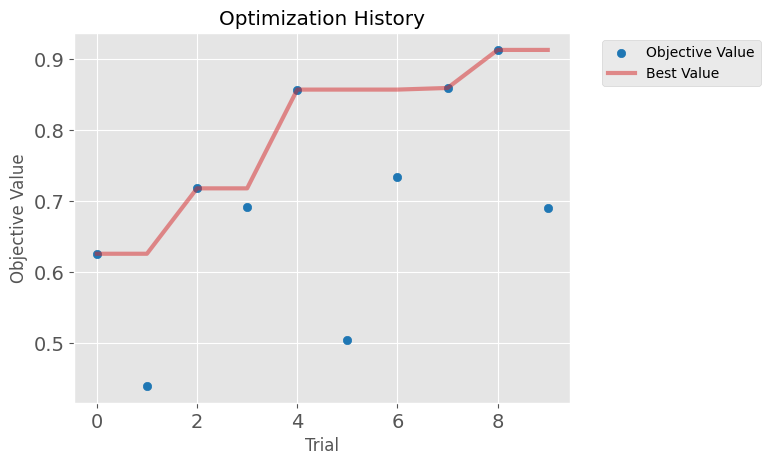

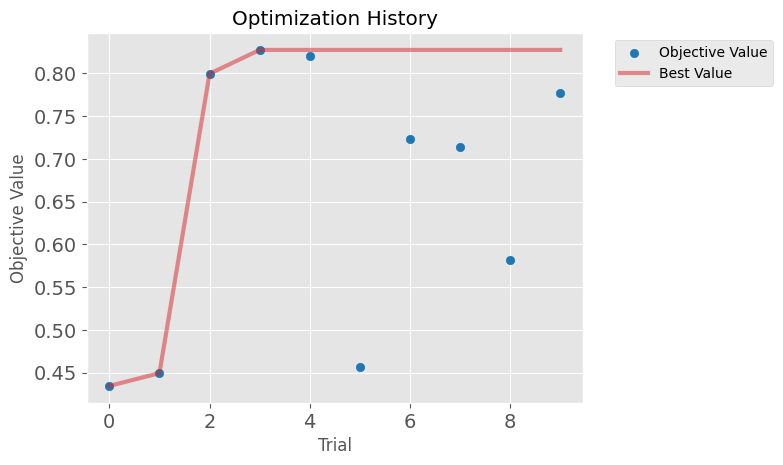

In [14]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_apples)
plt.title('Optimization History')
plt.show()

# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_grid)
plt.title('Optimization History')
plt.show()

Under the grid search approach, the objective values vary significantly because all possible combinations of hyperparameters in the grid are exhaustively evaluated.  
Since grid search does not take into account the performance of previous trials, it may waste resources evaluating many suboptimal configurations, especially in high-dimensional or redundant hyperparameter spaces.

In contrast, Optuna's search algorithm employs a more intelligent, adaptive sampling strategy (such as TPE).
It uses the results of previous trials to guide the search toward more promising regions of the hyperparameter space, allowing for a more efficient and focused exploration.
As a result, Optuna is often able to identify better-performing hyperparameter configurations with fewer trials compared to grid search.

The larger and more complex the search space becomes, the more pronounced the advantage of adaptive sampling methods like Optuna over exhaustive methods like grid search.

## Conclusion

Congratulations on completing the hyperparameter optimization tutorial with Optuna!

In this notebook, you explored the key components of an Optuna-based optimization workflow: defining the objective function, setting up the study, and analyzing the results. You also built a flexible CNN architecture designed to accommodate varying hyperparameter configurations, allowing for more dynamic experimentation.

Additionally, you compared Optuna’s default search algorithm (TPE) with a traditional grid search, demonstrating the efficiency and adaptability of Optuna in navigating complex hyperparameter spaces. Throughout the tutorial, you evaluated model performance using multiple metrics and learned how to interpret results through Optuna’s powerful visualization tools.

By the end of this tutorial, you’ve gained a practical and conceptual understanding of how to integrate Optuna into deep learning projects, equipping you with a valuable skill for optimizing model performance efficiently and effectively.